In [5]:
import MIMENet
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
#set path to simulation data
simulation_path = "/mnt/d/data/MIME_data/simData/dmMIME/highSpecies"

In [7]:
#set training parameters
training_path = simulation_path+'/data/trainingData.txt'
test_path = simulation_path+'/data/testData.txt'
epochs = 10
learning_rate = 0.0001
batch_size = 2048
lambda_l1 = 0.00001
hidden_size_factor = 5
bottleneck = 1/5

In [8]:
model, train_history, mae_history = MIMENet.train(training_path, test_path, epochs, learning_rate, batch_size, lambda_l1, hidden_size_factor, bottleneck)

Device: cuda:0
Epoch: 1/10


100%|██████████| 4819/4819 [02:08<00:00, 37.54it/s]


Epoch: 2/10


100%|██████████| 4819/4819 [02:03<00:00, 39.05it/s]


Epoch: 3/10


100%|██████████| 4819/4819 [01:54<00:00, 42.00it/s]


Epoch: 4/10


100%|██████████| 4819/4819 [01:58<00:00, 40.80it/s]


Epoch: 5/10


100%|██████████| 4819/4819 [02:02<00:00, 39.49it/s]


Epoch: 6/10


100%|██████████| 4819/4819 [02:07<00:00, 37.90it/s]


Epoch: 7/10


100%|██████████| 4819/4819 [02:06<00:00, 38.10it/s]


Epoch: 8/10


100%|██████████| 4819/4819 [02:06<00:00, 38.01it/s]


Epoch: 9/10


100%|██████████| 4819/4819 [02:07<00:00, 37.92it/s]


Epoch: 10/10


100%|██████████| 4819/4819 [02:05<00:00, 38.29it/s]


In [9]:
#save model
torch.save(model.state_dict(), './model.pth')

In [10]:
#save training history and mae history
np.savetxt('./train_history.txt', train_history)
np.savetxt('./mae_history.txt', mae_history)

In [11]:
#load saved model, training history, and mae history
input_size = len(open(training_path).readline().split(' ')) - 1
model = MIMENet.MIMENet(input_size, hidden_size_factor, bottleneck, 1)
model.load_state_dict(torch.load('./model.pth'))
#puto model to gpu
model.to('cuda:0')
#put model in eval mode
model.eval()
train_history = np.loadtxt('./train_history.txt')
mae_history = np.loadtxt('./mae_history.txt')

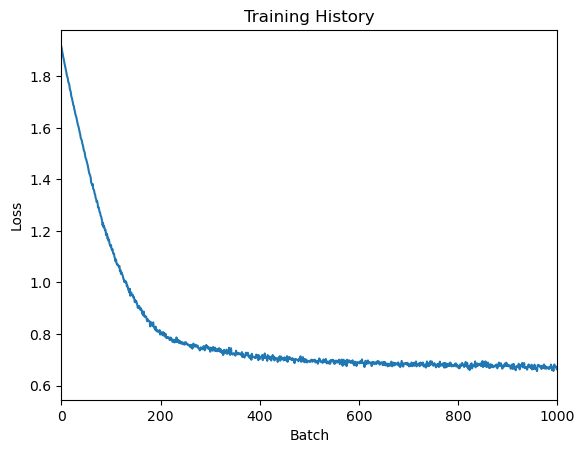

In [12]:
#plot training history
plt.plot(train_history)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Batch")
#limit x axis
plt.xlim(0, 1000)
plt.show()

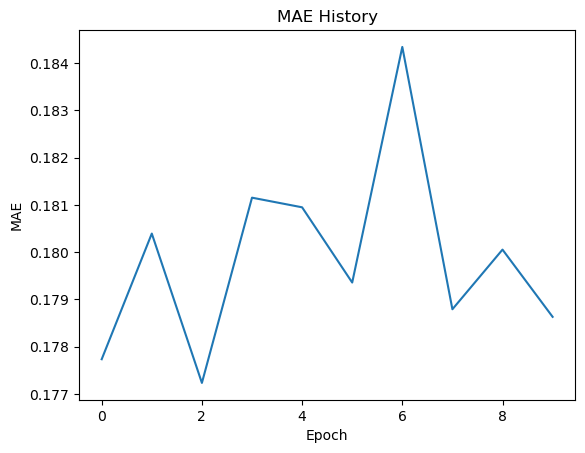

In [13]:
#plot mae history
plt.plot(mae_history)
plt.title("MAE History")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.show()

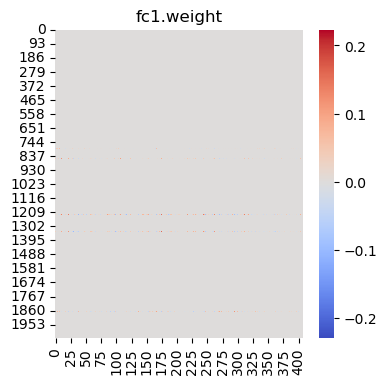

max weight value:  0.2231849
min weight value:  -0.22842611
number of pruned weights:  454472
number of non zero weights:  377848


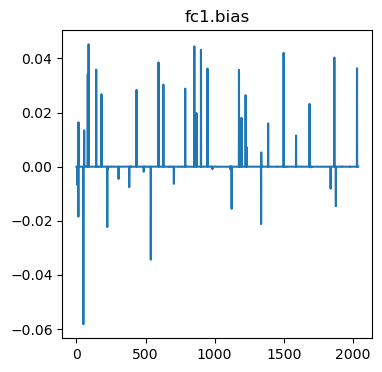

max bias value:  0.045239642
min bias value:  -0.05824394
number of pruned biases:  984
number of non zero biases:  1056


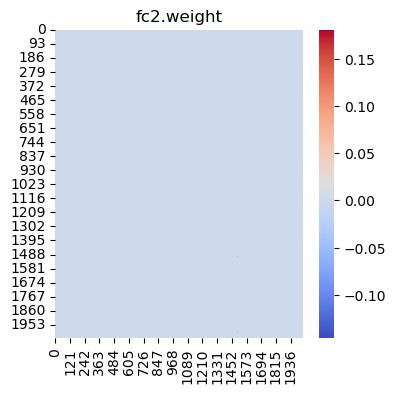

max weight value:  0.18062523
min weight value:  -0.14538582
number of pruned weights:  2585708
number of non zero weights:  1575892


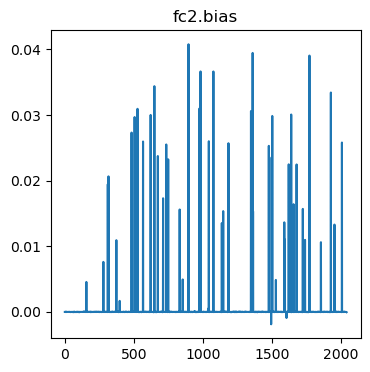

max bias value:  0.040769365
min bias value:  -0.0018813194
number of pruned biases:  1037
number of non zero biases:  1003


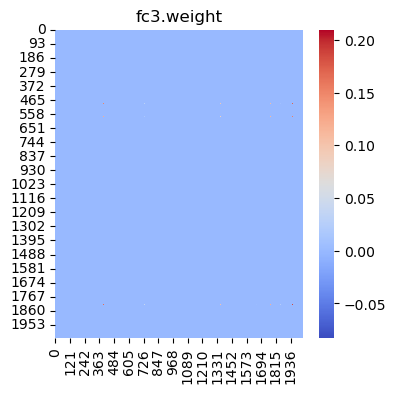

max weight value:  0.20959999
min weight value:  -0.08253279
number of pruned weights:  2568950
number of non zero weights:  1592650


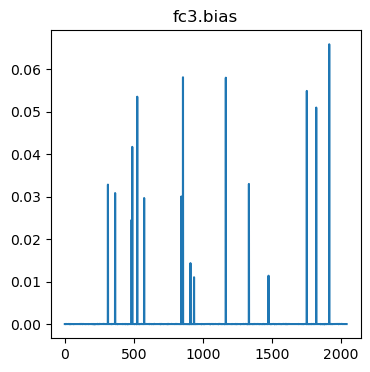

max bias value:  0.065927856
min bias value:  -5.5852608e-05
number of pruned biases:  1140
number of non zero biases:  900


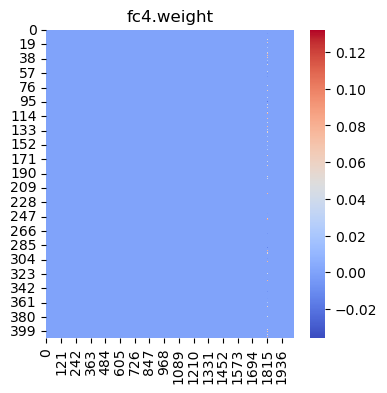

max weight value:  0.13213699
min weight value:  -0.035658095
number of pruned weights:  494766
number of non zero weights:  337554


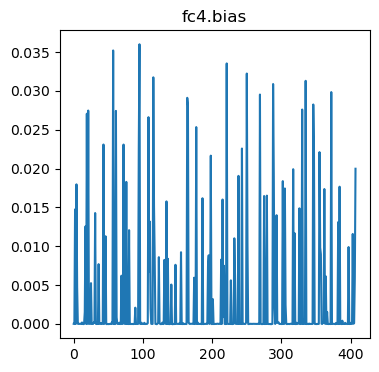

max bias value:  0.035989467
min bias value:  -4.3885884e-05
number of pruned biases:  162
number of non zero biases:  246


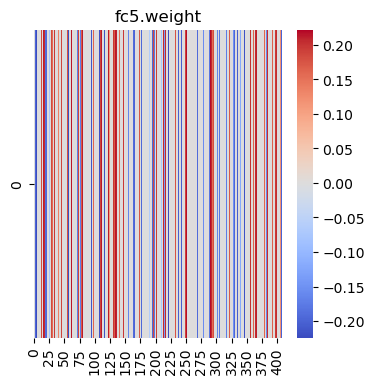

max weight value:  0.22202615
min weight value:  -0.22406599
number of pruned weights:  161
number of non zero weights:  247


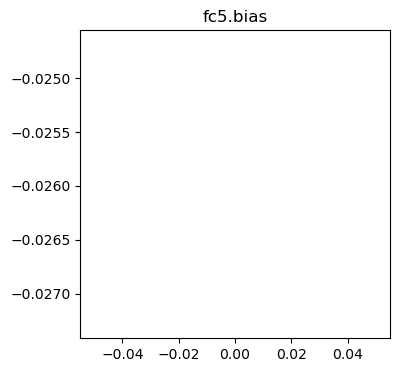

max bias value:  -0.025985634
min bias value:  -0.025985634
number of pruned biases:  0
number of non zero biases:  1


In [14]:
for name, param in model.named_parameters():
    #if weight is not a bias
    if 'bias' not in name:
        #reshape weights to 2d array
        weight = param.data.cpu().numpy().reshape(param.data.cpu().numpy().shape[0], param.data.cpu().numpy().shape[1])
        #plot heatmap of weights
        plt.figure(figsize=(4,4))
        sns.heatmap(weight, cmap='coolwarm')
        plt.title(name)
        plt.show()

        print('max weight value: ', np.max(weight))
        print('min weight value: ', np.min(weight))
        #print('number of weights: ', weight.size)
        print('number of pruned weights: ', np.sum(weight == 0))
        print('number of non zero weights: ', np.sum(weight != 0))

    else:
        bias = param.data.cpu().numpy()
        #plot histogram of biases
        plt.figure(figsize=(4,4))
        sns.lineplot(bias.flatten())
        plt.title(name)
        plt.show()
 
        print('max bias value: ', np.max(bias))
        print('min bias value: ', np.min(bias))
        #print('number of biases: ', bias.size)
        print('number of pruned biases: ', np.sum(bias == 0))
        print('number of non zero biases: ', np.sum(bias != 0))

In [15]:
# read in kd values
kds = np.loadtxt(simulation_path+'/secondFromProt1/prot1/single_kds.txt')

#insert 1 at position 0 and then every 3rd position
kds = np.insert(kds, 0, 1)
kds = np.insert(kds, np.arange(4, len(kds), 3), 1)
kds[0:10]

array([1.      , 0.299539, 3.60582 , 1.      , 1.      , 0.903664,
       1.      , 0.64211 , 1.      , 0.291765])

In [16]:
predictions = []
prediction_example = np.zeros(len(kds)+8)
for i in range(8, len(kds)+8):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    current_prediction_example = prediction_example.copy()
    current_prediction_example[i] = 1
    current_prediction_example = torch.from_numpy(current_prediction_example).float()
    current_prediction_example = current_prediction_example.to(device)
    #output binding probability and append list for given protein concentration combination
    with torch.no_grad():
        output = model(current_prediction_example)
        predictions.append(output.item())

predictions[0:10]

[0.49575120210647583,
 0.6371930241584778,
 0.2768249213695526,
 0.4786992073059082,
 0.4893868863582611,
 0.4958365261554718,
 0.4791407883167267,
 0.5595384240150452,
 0.49522724747657776,
 0.6595029234886169]

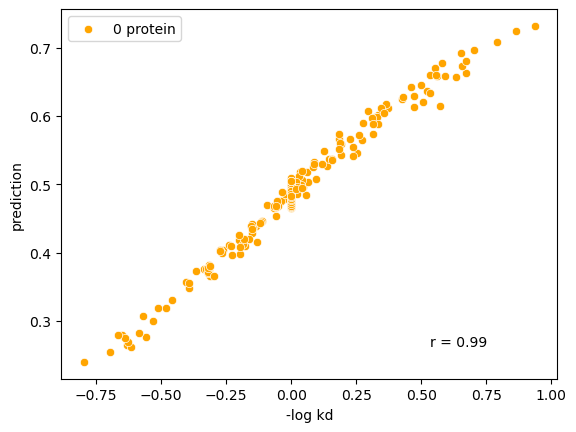

In [17]:
#two plots -log kd vs predictionZeroConc and predictionOneConc
sns.scatterplot(x=-np.log10(kds), y=predictions, label='0 protein', color='orange')
plt.xlabel('-log kd')
plt.ylabel('prediction')
#show correlation coefficient in bottom right corner
plt.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(-np.log10(kds), predictions)[0,1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

Text(0, 0.5, 'z score')

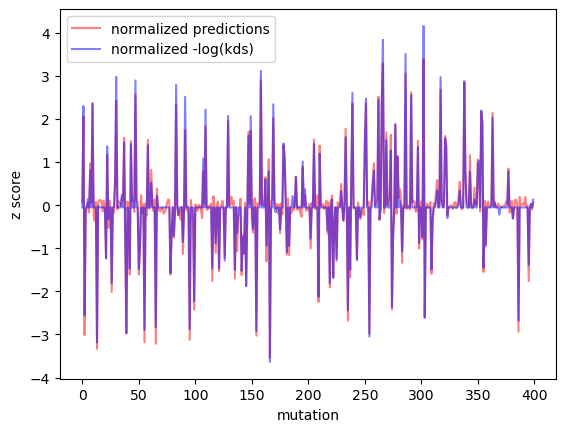

In [18]:
#z score predictions
predictionsNorm = (predictions - np.mean(predictions))/np.std(predictions)

#z score -np.log(kds)
kdsNorm = (-np.log10(kds) - np.mean(-np.log10(kds)))/np.std(-np.log10(kds))

#lineplot of z score predictions
sns.lineplot(x=np.arange(0, len(predictionsNorm)), y=predictionsNorm, label='normalized predictions', color='red', alpha=0.5)
sns.lineplot(x=np.arange(0, len(kdsNorm)), y=kdsNorm, label='normalized -log(kds)', color='blue', alpha=0.5)
plt.xlabel('mutation')
plt.ylabel('z score')

(0.0, 1.0)

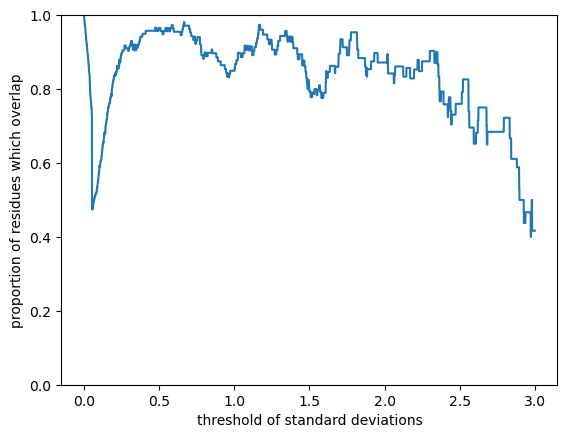

In [19]:
#check overlap of normalized predictions and normalized -log(kds) for absolute value greater than 0.5
#loop over threshold values
overlapProportions = []
for threshold in np.arange(0, 3, 0.001):
    #get indices of scaled predictions and scaled -log(kds) that are greater than the threshold
    indices = np.where(np.abs(predictionsNorm) > threshold)[0]
    indices2 = np.where(np.abs(kdsNorm) > threshold)[0]
    #get the intersection of the two sets of indices
    overlap = np.intersect1d(indices, indices2)
    #get the proportion of the intersection to the union of the two sets of indices
    overlapProportions.append(len(overlap)/len(np.union1d(indices, indices2)))

#plot overlapProportions
sns.lineplot(x=np.arange(0, 3, 0.001), y=overlapProportions)
plt.xlabel('threshold of standard deviations')
plt.ylabel('proportion of residues which overlap')
plt.ylim(0, 1)

In [20]:
input_size = len(open(training_path).readline().split(' ')) - 1
predictionsPairwise = []
prediction_example = np.zeros(input_size)
for i in range(8, input_size,4):
    for j in range(i+4, input_size,4):
        for k in range(1,4):
            for l in range(1,4):
                    current_prediction_example = prediction_example.copy()
                    current_prediction_example[i+k] = 1
                    current_prediction_example[j+l] = 1
                    current_prediction_example = torch.from_numpy(current_prediction_example).float()
                    current_prediction_example = current_prediction_example.to(device)
                    #output binding probability and append list for given protein concentration combination
                    with torch.no_grad():
                        output = model(current_prediction_example)
                        predictionsPairwise.append(output.item())
                    #print(i+k, j+l)
len(predictionsPairwise)

44550

In [21]:
#load pairwise kd values
kdsPairwise = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_kds.txt')
kdsPairwise[0:10]

array([0.270683, 0.299539, 0.192337, 3.25845 , 3.60582 , 2.31533 ,
       0.903664, 1.      , 0.64211 , 0.087395])

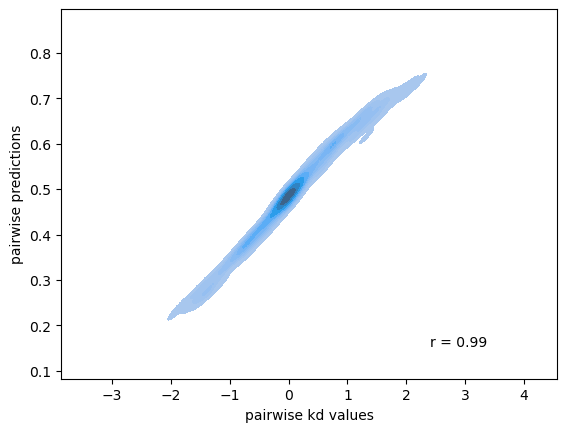

In [22]:
#get correlation coefficient
np.corrcoef(-np.log(kdsPairwise), predictionsPairwise)[0,1]
#density plot pairwise predictions vs pairwise kd values
sns.kdeplot(x=-np.log(kdsPairwise), y=predictionsPairwise, fill=True)
plt.xlabel('pairwise kd values')
plt.ylabel('pairwise predictions')
#show correlation coefficient in bottom right corner
plt.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(-np.log(kdsPairwise), predictionsPairwise)[0,1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [23]:
input_size = len(open(training_path).readline().split(' ')) - 1
epistasisPairwise = []
prediction_example = np.zeros(input_size)
for i in range(8, input_size,4):
    for j in range(i+4, input_size,4):
        for k in range(1,4):
            for l in range(1,4):
                    current_prediction_example_pos1 = prediction_example.copy()
                    current_prediction_example_pos1[i+k] = 1
                    current_prediction_example_pos1 = torch.from_numpy(current_prediction_example_pos1).float()
                    current_prediction_example_pos1 = current_prediction_example_pos1.to(device)
                    current_prediction_example_pos2 = prediction_example.copy()
                    current_prediction_example_pos2[j+l] = 1
                    current_prediction_example_pos2 = torch.from_numpy(current_prediction_example_pos2).float()
                    current_prediction_example_pos2 = current_prediction_example_pos2.to(device)
                    current_prediction_example_pair = prediction_example.copy()
                    current_prediction_example_pair[i+k] = 1
                    current_prediction_example_pair[j+l] = 1
                    current_prediction_example_pair = torch.from_numpy(current_prediction_example_pair).float()
                    current_prediction_example_pair = current_prediction_example_pair.to(device)
                    #get binding probabilities of pos1, pos2, and pos1+pos2
                    with torch.no_grad():
                        output_pos1 = model(current_prediction_example_pos1)
                        output_pos2 = model(current_prediction_example_pos2)
                        output_pair = model(current_prediction_example_pair)
                        #get epistasis value and append list for given protein concentration combination
                        epistasisPairwise.append((output_pos1.item()*output_pos2.item())/output_pair.item())
print(len(epistasisPairwise))
print(epistasisPairwise[0:10])

In [ ]:
#load pairwise epistasis values
epistasisPairwiseSim = np.log(np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_epistasis.txt'))
epistasisPairwiseSim[0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

(-10.0, 10.0)

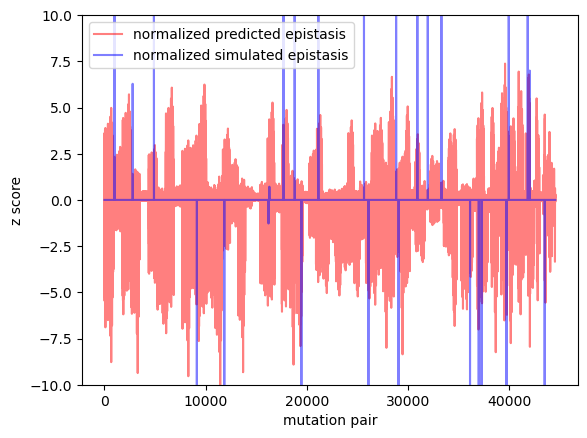

In [ ]:
#normalize predictions and epistasis values
epistasisPairwiseNorm = (epistasisPairwise - np.mean(epistasisPairwise))/np.std(epistasisPairwise)
epistasisPairwiseSimNorm = (epistasisPairwiseSim - np.mean(epistasisPairwiseSim))/np.std(epistasisPairwiseSim)

#lineplot of z score predictions
sns.lineplot(x=np.arange(0, len(epistasisPairwise)), y=epistasisPairwiseNorm, label='normalized predicted epistasis', color='red', alpha=0.5)
sns.lineplot(x=np.arange(0, len(epistasisPairwiseSim)), y=epistasisPairwiseSimNorm, label='normalized simulated epistasis', color='blue', alpha=0.5)
plt.xlabel('mutation pair')
plt.ylabel('z score')
plt.ylim(-10, 10)